In [139]:
import numpy as np
import pandas as pd
import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
sys.path.insert(1, module_path + '/src')

from sktime.utils.data_io import load_from_tsfile_to_dataframe
from sktime.utils.data_processing import from_nested_to_2d_array


from minisom import MiniSom

import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
from matplotlib.patches import RegularPolygon, Ellipse
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import cm, colorbar
from matplotlib.lines import Line2D

from bokeh.colors import RGB
from bokeh.io import curdoc, show, output_notebook
from bokeh.transform import factor_mark, factor_cmap
from bokeh.models import ColumnDataSource, HoverTool
from bokeh.plotting import figure, output_file

from matplotlib.font_manager import FontProperties
from matplotlib.colors import LinearSegmentedColormap
font = FontProperties(fname = module_path + '/src/visualization/CharterRegular.ttf', size = 10, weight = 1000)
font_small = FontProperties(fname = module_path + '/src/visualization/CharterRegular.ttf', size = 8, weight = 1000)

colors = ['#F94144', '#F3722C', '#F8961E', '#F9844A', '#F9C74F', '#90BE6D', '#43AA8B', '#4D908E', '#577590', '#277DA1']

cmap = ['#F94144', '#277DA1']

cmap_name = 'my colormap'

c_map = LinearSegmentedColormap.from_list(cmap_name, cmap)


# display matplotlib plots in notebook
%matplotlib inline
# display bokeh plot in notebook
output_notebook()

Loading BokehJS ...

In [36]:
X_train, y_train = load_from_tsfile_to_dataframe(module_path + '/features/extracted_features_ts_files/lungsound_preproject_TRAIN.ts')

X_test, y_test = load_from_tsfile_to_dataframe(module_path + '/features/extracted_features_ts_files/lungsound_preproject_TEST.ts')

X_train = from_nested_to_2d_array(X_train)
X_test = from_nested_to_2d_array(X_test)

y_test = y_test.astype(int)
y_train = y_train.astype(int)

X_train.columns = np.arange(len(X_train.columns))
X_test.columns = np.arange(len(X_test.columns))


X_train = X_train.to_numpy()

## SOM for finding clusters

In [75]:
size_som = 30

som = MiniSom(size_som, size_som, X_train.shape[1], sigma=5, learning_rate=0.5, 
              neighborhood_function='triangle', random_seed=10)
som.pca_weights_init(X_train)
som.train(X_train, 1000, verbose=True)

 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 1.123020227105689


In [76]:
xx, yy = som.get_euclidean_coordinates()
umatrix = som.distance_map()
weights = som.get_weights()

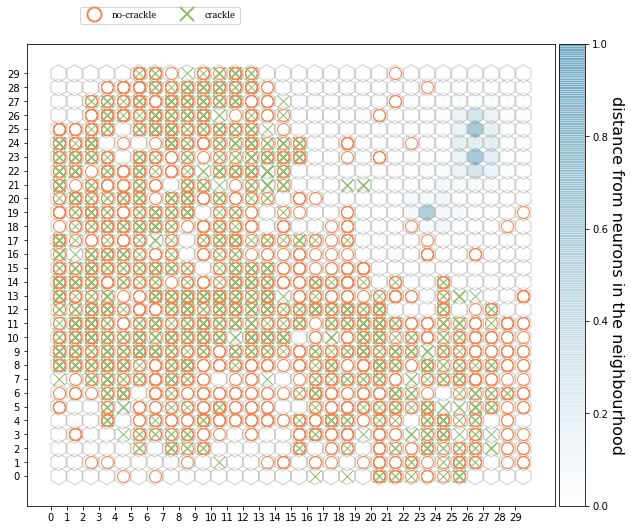

In [77]:
f = plt.figure(figsize=(10,10))
ax = f.add_subplot(111)

ax.set_aspect('equal')

# iteratively add hexagons
for i in range(weights.shape[0]):
    for j in range(weights.shape[1]):
        wy = yy[(i, j)] * 2 / np.sqrt(3) * 3 / 4
        hex = RegularPolygon((xx[(i, j)], wy), 
                             numVertices=6, 
                             radius=.95 / np.sqrt(3),
                             facecolor=c_map(umatrix[i, j]), 
                             alpha=.4, 
        b                     edgecolor='gray')
        ax.add_patch(hex)

markers = ['o', 'x']
label_colors  = [colors[3], colors[5]]
for cnt, x in enumerate(X_train):
    # getting the winner
    w = som.winner(x)
    # place a marker on the winning position for the sample xx
    wx, wy = som.convert_map_to_euclidean(w) 
    wy = wy * 2 / np.sqrt(3) * 3 / 4

    plt.plot(wx, wy, 
             markers[y_train[cnt]], 
             markerfacecolor='None',
             markeredgecolor=label_colors[y_train[cnt]], 
             markersize=12, 
             markeredgewidth=1)
    
xrange = np.arange(weights.shape[0])
yrange = np.arange(weights.shape[1])
plt.xticks(xrange-.5, xrange)
plt.yticks(yrange * 2 / np.sqrt(3) * 3 / 4, yrange)

divider = make_axes_locatable(plt.gca())
ax_cb = divider.new_horizontal(size="5%", pad=0.05)    
cb1 = colorbar.ColorbarBase(ax_cb, cmap=c_map, 
                            orientation='vertical', alpha=.4)
cb1.ax.get_yaxis().labelpad = 16
cb1.ax.set_ylabel('distance from neurons in the neighbourhood',
                  rotation=270, fontsize=16)
plt.gcf().add_axes(ax_cb)
legend_elements = [Line2D([0], [0], marker='o', color=label_colors[0], label='no-crackle',
                   markerfacecolor='w', markersize=14, linestyle='None', markeredgewidth=2),
                   Line2D([0], [0], marker='x', color=label_colors[1], label='crackle',
                   markerfacecolor='w', markersize=14, linestyle='None', markeredgewidth=2)]
ax.legend(handles=legend_elements, bbox_to_anchor=(0.1, 1.08), loc='upper left', 
          borderaxespad=0., ncol=2, prop = font)

#plt.savefig('resulting_images/som_seed_hex.png')
plt.show()

# Autoencoder suppressed into two features 

In [78]:
import pandas as pd
from sklearn.model_selection import train_test_split
import os
import sys
from sklearn import preprocessing
from concrete_autoencoder import ConcreteAutoencoderFeatureSelector
from keras.datasets import mnist
from keras.utils import to_categorical
from keras.layers import Dense, Dropout, LeakyReLU, Softmax
import numpy as np
from sklearn.preprocessing import LabelEncoder

module_path = os.path.abspath(os.path.join('../..'))
sys.path.insert(1, module_path + '/src')

import utility
metrics = {}

In [ ]:
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.fit_transform(y_test)


x_train, x_test = X_train, X_test
x_train = np.reshape(x_train, (len(x_train), -1))
x_test = np.reshape(x_test, (len(x_test), -1))

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

def f(x):
    x = Dense(320)(x)
    x = LeakyReLU(0.2)(x)
    x = Dropout(0.1)(x)
    x = Dense(320)(x)
    x = LeakyReLU(0.2)(x)
    x = Dropout(0.1)(x)
    x = Dense(X_train.shape[1])(x)
    return x

def g(x):
    x = Dense(320)(x)
    x = LeakyReLU(0.2)(x)
    x = Dropout(0.1)(x)
    x = Dense(320)(x)
    x = LeakyReLU(0.2)(x)
    x = Dropout(0.1)(x)
    x = Dense(1)(x)
    x = Softmax()(x)
    return x

#selector = ConcreteAutoencoderFeatureSelector(K = 20, output_function = f, num_epochs = 3)
selector_supervised = ConcreteAutoencoderFeatureSelector(K = 2, output_function = g, num_epochs = 10)

#selector.fit(x_train, x_train, x_test, x_test)
selector_supervised.fit(x_train, y_train, x_test, y_test)
features = selector_supervised.get_support(indices = True).tolist()

plot_data = { 'AE feature 1' : X_train[:,features[0]],
             'AE feature 2' : X_train[:,features[1]],
             'labels': y_train
}

### Plotting the two features kept by the autoencoder

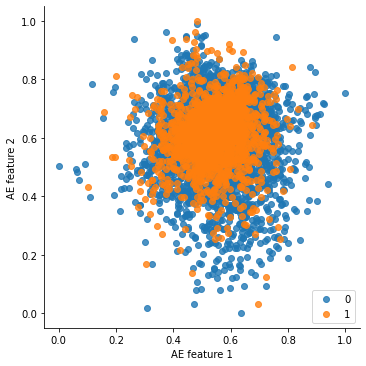

In [110]:
import seaborn as sns
# Use the 'hue' argument to provide a factor variable
sns.lmplot( x='AE feature 1', y='AE feature 2' ,
           data = pd.DataFrame(plot_data), fit_reg=False, hue='labels', legend=False)
 
# Move the legend to an empty part of the plot
plt.legend(loc='lower right')

plt.show()

## Plotting bottleneck layer of autoencoder

In [131]:
from keras.layers import Input, Dense
from keras.models import Model

encoding_dim = 2
input_layer = Input(shape=(X_train.shape[1],))
encoded = Dense(encoding_dim, activation='relu')(input_layer)
decoded = Dense(X_train.shape[1], activation='sigmoid')(encoded)

# let's create and compile the autoencoder
autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

In [133]:
# let's train the autoencoder, checking the progress on a validation dataset 
from sklearn.model_selection import train_test_split
X1, X2, Y1, Y2 = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
Y1 = np.asarray(Y1).astype('float32').reshape((-1,1))
Y2 = np.asarray(Y2).astype('float32').reshape((-1,1))


autoencoder.fit(X1, Y1,
                epochs=10,
                batch_size=200,
                shuffle=False,
                verbose = 2,
                validation_data=(X2, Y2))

Epoch 1/10
23/23 - 1s - loss: 5.2228 - val_loss: 4.9414
Epoch 2/10
23/23 - 0s - loss: 4.5615 - val_loss: 4.0142
Epoch 3/10
23/23 - 0s - loss: 3.3832 - val_loss: 2.5657
Epoch 4/10
23/23 - 0s - loss: 1.8843 - val_loss: 1.2425
Epoch 5/10
23/23 - 0s - loss: 0.9853 - val_loss: 0.8018
Epoch 6/10
23/23 - 0s - loss: 0.7518 - val_loss: 0.7068
Epoch 7/10
23/23 - 0s - loss: 0.7015 - val_loss: 0.6810
Epoch 8/10
23/23 - 0s - loss: 0.6830 - val_loss: 0.6691
Epoch 9/10
23/23 - 0s - loss: 0.6735 - val_loss: 0.6617
Epoch 10/10
23/23 - 0s - loss: 0.6677 - val_loss: 0.6570


In [182]:
# now let's evaluate the coding of the initial features
encoder = Model(input_layer, encoded)
ae = encoder.predict(X_train)
ae_test = encoder.predict(X_test)

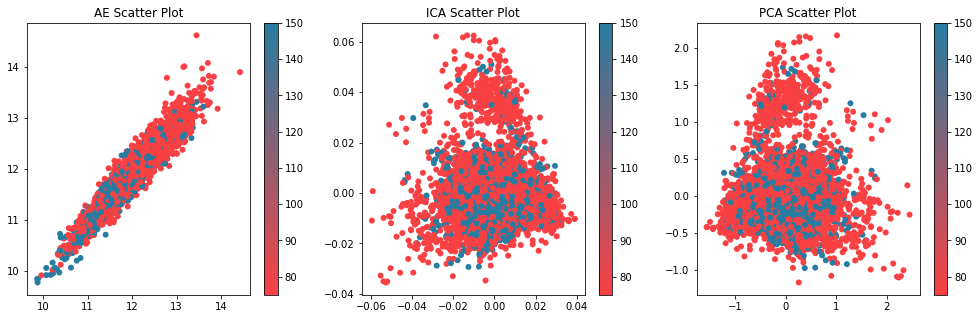

In [183]:
#... and let's plot the two components of the compression on a scatter plot that also shows 
# the y value associated to each point. PCA decomposition is provided as well for comparison
y = y_train
train = pd.DataFrame(X_train)

plt.figure(figsize = (17,5))
plt.subplot(131)
plt.scatter(ae[:,0],ae[:,1],  c = y*150, cmap = c_map, 
            edgecolor = "None", alpha=1, vmin = 75, vmax = 150)
plt.colorbar()
plt.title('AE Scatter Plot')


# ICA and PCA (first 2 components)
from sklearn.decomposition import PCA, FastICA # Principal Component Analysis module
ica = FastICA(n_components=2)
ica.fit(train.values)
ica_2d = ica.transform(train.values)
ica_2d_test = ica.transform(X_test)


plt.subplot(132)
plt.scatter(ica_2d[:,0],ica_2d[:,1],  c = y*150, cmap = c_map,
            edgecolor = "None", alpha=1, vmin = 75, vmax = 150)
plt.colorbar()
plt.title('ICA Scatter Plot')

pca = PCA(n_components=2)
pca.fit(train.values)
pca_2d = pca.transform(train.values)
pca_2d_test = pca.transform(X_test)


plt.subplot(133)
plt.scatter(pca_2d[:,0],pca_2d[:,1],  c = y*150, cmap = c_map,
            edgecolor = "None", alpha=1, vmin = 75, vmax = 150)
plt.colorbar()
plt.title('PCA Scatter Plot')

plt.show()

## TSNE

In [184]:
from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=2).fit_transform(X_train)
X_embedded_test = TSNE(n_components=2).fit_transform(X_test)

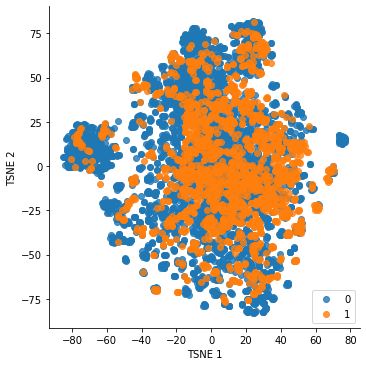

In [158]:
plot_data = { 'TSNE 1' : X_embedded[:,0],
             'TSNE 2' : X_embedded[:,1],
             'labels': y_train
}
# Use the 'hue' argument to provide a factor variable
sns.lmplot( x='TSNE 1', y='TSNE 2' ,
           data = pd.DataFrame(plot_data), fit_reg=False, hue='labels', legend=False)
 
# Move the legend to an empty part of the plot
plt.legend(loc='lower right')

plt.show()

# Elbow method to choose clusters

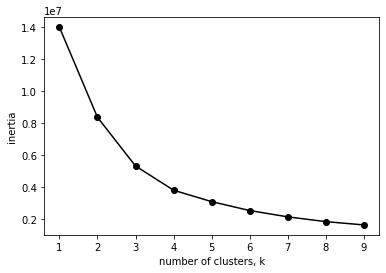

In [164]:
from sklearn.cluster import KMeans

ks = range(1, 10)
inertias = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)
    
    # Fit model to samples
    #model.fit(pca_2d) #PCA  --> 6
    #model.fit(ica_2d) # ICA  --> 4
    #model.fit(preds) # Autoencoder --> 3
    model.fit(X_embedded) # TSNE  --> 4
    
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

# Plotting with k means clusters

## TSNE

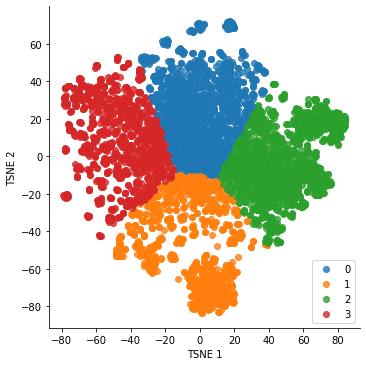

In [185]:
k = 4

model = KMeans(n_clusters=k)
model.fit(X_embedded)

plot_data = { 'TSNE 1' : X_embedded[:,0],
             'TSNE 2' : X_embedded[:,1],
             'labels': model.labels_
}
# Use the 'hue' argument to provide a factor variable
sns.lmplot( x='TSNE 1', y='TSNE 2' ,
           data = pd.DataFrame(plot_data), fit_reg=False, hue='labels', legend=False)
 
# Move the legend to an empty part of the plot
plt.legend(loc='lower right')

plt.show()

### PCA

firstly visualizing clusters in the training set

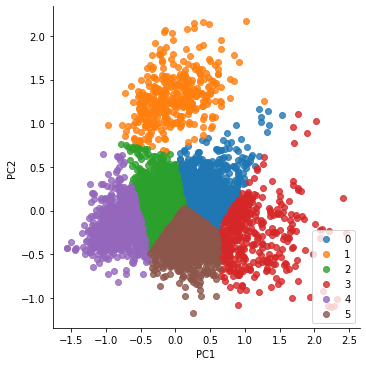

In [187]:
k = 6

model = KMeans(n_clusters=k)
model.fit(pca_2d)

plot_data = { 'PC1' : pca_2d[:,0],
             'PC2' : pca_2d[:,1],
             'labels': model.labels_
}
# Use the 'hue' argument to provide a factor variable
sns.lmplot( x='PC1', y='PC2' ,
           data = pd.DataFrame(plot_data), fit_reg=False, hue='labels', legend=False)
 
# Move the legend to an empty part of the plot
plt.legend(loc='lower right')

plt.show()

Visualizing clusters in the testing set

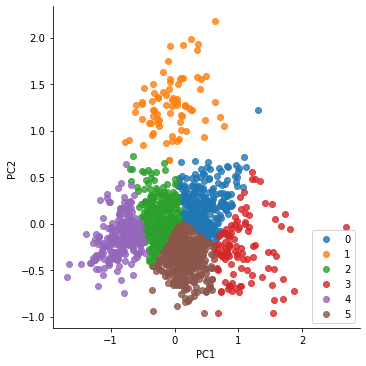

In [200]:
new_y_test = model.predict(pca_2d_test)
plot_data = { 'PC1' : pca_2d_test[:,0],
             'PC2' : pca_2d_test[:,1],
             'labels': new_y_test
}
# Use the 'hue' argument to provide a factor variable
sns.lmplot( x='PC1', y='PC2' ,
           data = pd.DataFrame(plot_data), fit_reg=False, hue='labels', legend=False)
 
# Move the legend to an empty part of the plot
plt.legend(loc='lower right')

plt.show()

cluster_dict = {}
for cluster in range(k): 
    cluster_dict[cluster] = np.where(new_y_test == cluster)[0]

Testing classifier on clusters vs classfier on entire training set

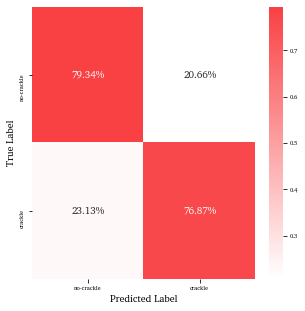

In [217]:
from sklearn.neighbors import KNeighborsClassifier


clf_init = KNeighborsClassifier(leaf_size=1, n_neighbors=1, p=1).fit(X_train, y_train)
y_pred_init = clf_init.predict(X_test)
score_init = {}
score_init['f1-score'] = f1_score(y_test, y_pred_init)
score_init['accuracy'] = accuracy_score(y_test, y_pred_init)
utility.plot_cm(y_test, y_pred_init, module_path = module_path)

Entire training-set results:

In [214]:
from sklearn.metrics import f1_score, accuracy_score

metrics = ['accuracy', 'f1-score']
scores = {k: [] for k in metrics}

percentage_of_del_idx = []
for cluster_nr, indices in cluster_dict.items():
    X_test_temp = X_test.iloc[indices]
    y_test_temp = y_test[indices]
    percentage_of_del_idx.append(1 - X_test_temp.shape[0]/X_test.shape[0])
    y_pred = clf_init.predict(X_test_temp)
    scores['accuracy'].append(accuracy_score(y_test_temp, y_pred))
    scores['f1-score'].append(f1_score(y_test_temp, y_pred))